In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import torch
from zisnmf import ZISNMF,add_V_components_to_anndata,plot_rank_genes_groups

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)



/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read_h5ad('/home/oem/Workspace/SUREMO_Ex/blood/NeurIPS2021/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
adata.X = adata.layers['counts'].copy()

genes=adata.var_names[adata.var['feature_types']=='GEX']
adata=adata[:,genes].copy()

In [3]:
adata.obs['n_features'] = np.sum(adata.X>0, axis=1)
nonzero_features = np.sum(adata.X>0, axis=0)>0

adata = adata[:,nonzero_features]

features =[x for x in adata.var_names if (not x.startswith('RPS')) and (not x.startswith('RPL')) and (not x.startswith('MT-'))]
adata = adata[:,features]
adata.shape

(69249, 13323)

In [4]:
cluster_name = 'cell_type'

n_cells = adata.shape[0]
n_genes = adata.shape[1]
n_clusters = adata.obs[cluster_name].unique().shape[0]
n_extra_states = 100


In [5]:
annot_groups = adata.obs[cluster_name].values
annot_labels = encoder.fit_transform(annot_groups.reshape(-1,1))
annot_labels = np.argmax(annot_labels, axis=1)

L = torch.zeros((n_cells, n_clusters))
L[np.arange(n_cells), annot_labels] = 1.0

In [6]:
num_epochs = 30
learning_rate = 0.001
alpha = 0.2
batch_size=1024


model = ZISNMF(n_cells, n_genes, n_clusters, n_extra_states, random_seed=42, delta=0.0, device=torch.device('cuda'))
M, V, _, _ = model.fit_transform(adata.X.toarray(), L, num_epochs=num_epochs, learning_rate=learning_rate, alpha=alpha, batch_size=batch_size)


Training: 100%|██████████| 30/30 [02:14<00:00,  4.48s/epoch, loss=4.41e+7]


In [7]:
V_df = pd.DataFrame(V, index=encoder.categories_[0].tolist(), columns=adata.var_names)
V_df.head()

,AL627309.5,LINC01409,LINC01128,NOC2L,KLHL17,ISG15,C1orf159,SDF4,B3GALT6,UBE2J2,...,CMC4,MTCP1,BRCC3,VBP1,CLIC2,TMLHE-AS1,TMLHE,VAMP7,AL592183.1,AC240274.1
B1 B,0.003166,0.006098,0.009226,0.015569,0.006152,0.035180,0.011989,0.029974,0.006544,0.014133,...,0.000810,0.007003,0.025603,0.015393,0.000611,0.022020,0.046795,0.006651,0.054387,0.002705
CD14+ Mono,0.011737,0.014973,0.005671,0.018379,0.002178,0.033493,0.017058,0.018005,0.004328,0.031644,...,0.000647,0.004342,0.019848,0.010995,0.002831,0.027583,0.056807,0.013772,0.023991,0.002947
CD16+ Mono,0.007283,0.013373,0.009038,0.024482,0.003103,0.110750,0.016900,0.027293,0.005603,0.032676,...,0.000344,0.002299,0.025608,0.010317,0.006510,0.050220,0.064314,0.012404,0.021623,0.003176
CD4+ T activated,0.000289,0.017308,0.018626,0.024826,0.002481,0.050883,0.018973,0.033369,0.008935,0.030529,...,0.002871,0.006290,0.023972,0.023062,0.003273,0.017986,0.025552,0.011603,0.043199,0.000171
CD4+ T naive,0.000000,0.018365,0.012811,0.019645,0.004038,0.051439,0.018038,0.030223,0.009346,0.032094,...,0.008966,0.006734,0.021111,0.022756,0.000768,0.021635,0.029555,0.009723,0.023817,0.001011


In [8]:
V_adata = sc.AnnData(V_df.values, obs=pd.DataFrame(encoder.categories_[0], columns=[cluster_name]))
V_adata.var_names=adata.var_names
V_adata.obs['cluster'] = V_adata.obs[cluster_name].astype('category')

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
known_marker_genes_dict = {'CD14+ Mono':['CD14'],
                      'CD16+ Mono':['FCGR3A'],
                      'pDC':['TCF4'],
                      'cDC2':[],
                      'Naive CD20+ B':['IGHD'],
                      'B1 B':['MS4A1'],
                      'Transitional B':['MME'],
                      'Plasma cell':['MZB1'],
                      'CD4+ T naive':['CD4'],
                      'CD4+ T activated':['IL7R'],
                      'CD8+ T':['CD8A'],
                      'CD8+ T naive':[],
                      'NK':['FCER1G'],
                      'ILC':['ID2'],
                      'HSC':['MECOM'],
                      'G/M prog':['MPO'],
                      'ID2-hi myeloid prog':['KLF4'],
                      'Lymph prog':['IGLL1'],
                      'MK/E prog':['ITGA2B'],
                      'Proerythroblast':['SYNGR1'],
                      'Erythroblast':['MKI67'],
                      'Normoblast':['SLC4A1']}

known_marker_genes = list()
for k in known_marker_genes_dict.keys():
    known_marker_genes.extend(known_marker_genes_dict[k])


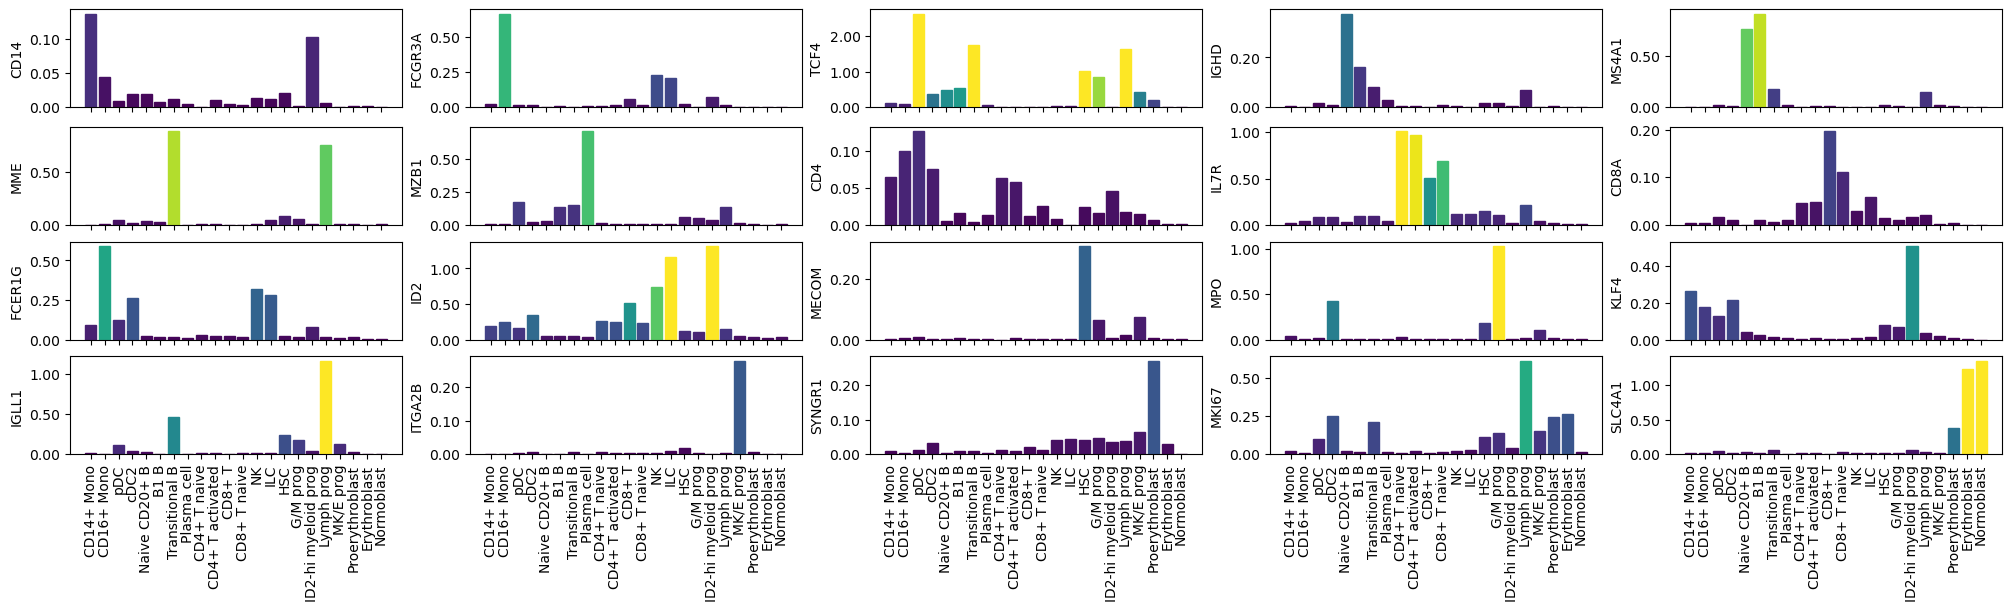

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

df = V_df.loc[list(known_marker_genes_dict.keys()),:][known_marker_genes]


# Number of columns and subplots configuration
num_plots = df.shape[1]
num_columns = 5
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

# Create subplots with constrained_layout for better alignment
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 1.5), sharex=True, constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes

# Determine the global y limits
global_y_min = df.min().min()
global_y_max = df.max().max()

# Function to format y-axis labels with two decimal places
def format_func(value, tick_number):
    return f"{value:.2f}"

# Plot each column in a separate subplot
for idx, col in enumerate(df.columns):
    ax = axes[idx]
    values = df[col]
    bars = ax.bar(df.index, values, color=sns.color_palette("viridis", len(values)))
    ax.set_ylabel(col)
    #ax.set_ylim(global_y_min, global_y_max)  # Set consistent y limits
    
    # Format y-axis labels
    ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    
    # Color bars according to their values
    for bar, value in zip(bars, values):
        bar.set_color(sns.color_palette("viridis", as_cmap=True)(value))

# Set x-axis labels for the bottom subplots only
for ax in axes[-num_columns:]:
    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=90)


# Remove any unused subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])


# Adjust layout with constrained_layout
plt.show()